# Imbalanced Labels and Athletes Similar to Olympic Medalists

In [ ]:
# # running on colab
# !git clone https://github.com/vistec-AI/wangchan-analytica.git
# %cd wangchan-analytica/
# !pip install -r requirements.txt

In [1]:
#reload scripts when we edit them
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import qgrid

In [2]:
df = pd.read_csv('data/olympic/athlete_events.csv', encoding='utf8')
print(df.shape)
qgrid.show_grid(df)

(271116, 15)


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [3]:
#we're only interested in medalist or not
df['Medal'] = df.Medal.map(lambda x: 1 if x==x else 0)
df.Medal.mean()

0.14673792767671404

## Coding Assignment

Using only `Sex`, `Age`, `Height`, `Weight`, `Sport`, `City`, `Season` and `Team`, predict whether an athelete is a medalist or not.

In [4]:
df = df[['Sex','Age','Height','Weight','Sport','City','Season','Team','Medal']].copy()
train = df.sample(int(df.shape[0]*0.8))
test = df.drop(train.index, errors="ignore")
train.shape, test.shape

((216892, 9), (54224, 9))

In [5]:
import utils
for col in ['Sex','Sport','City','Season','Team']:
    #use same dict for train and test
    d = utils.other_dict(train,col,0.03)
    train = utils.otherify(train,col,d)
    test = utils.otherify(test,col,d)
train = utils.missingify(train).drop('Medal_missing',1)
test = utils.missingify(test).drop('Medal_missing',1)

Index(['Sex', 'Sport', 'City', 'Season', 'Team'], dtype='object')
Index(['Sex', 'Sport', 'City', 'Season', 'Team'], dtype='object')


In [6]:
test.head()

,Sex,Sport,City,Season,Team,Age,Height,Weight,Medal,Age_missing,Height_missing,Weight_missing
0,M,others,London,Summer,others,23.0,170.0,60.0,0.0,0.0,0.0,0.0
1,F,others,others,Winter,others,25.0,185.0,82.0,0.0,0.0,0.0,0.0
2,M,Cross Country Skiing,others,Winter,United States,33.0,188.0,75.0,0.0,0.0,0.0,0.0
3,M,Cross Country Skiing,others,Winter,United States,33.0,183.0,72.0,0.0,0.0,0.0,0.0
4,M,Swimming,Helsinki,Summer,others,26.0,175.0,70.0,0.0,0.0,1.0,1.0


In [7]:
#y
y_train = np.array(train.Medal)
y_test = np.array(test.Medal)
train = train.drop('Medal',1)
test = test.drop('Medal',1)
y_train.shape,y_test.shape

((216892,), (54224,))

In [8]:
#X_cat
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(categories=[list(train[col].unique())+['xxna'] for col in train.columns[:5]])

feature_cols = list(train.columns[:5])
X_train_cat = train[feature_cols].values
enc_fit = enc.fit(X_train_cat)
X_train_cat = enc_fit.transform(X_train_cat).toarray()
X_test_cat = enc_fit.transform(test.iloc[:,:5]).toarray()
X_train_cat.shape,X_test_cat.shape

((216892, 41), (54224, 41))

In [9]:
#X
X_train = np.concatenate([X_train_cat,train.iloc[:,5:]],1)
X_test = np.concatenate([X_test_cat,test.iloc[:,5:]],1)
X_train.shape,X_test.shape

((216892, 47), (54224, 47))

In [10]:
#standardize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler_fit = scaler.fit(X_train)
X_train = scaler_fit.transform(X_train)
X_test = scaler_fit.transform(X_test)

In [11]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)
print(f'Accuracy: {clf.score(X_test,y_test)}') 

Accuracy: 0.8395728828562998


**Conceptual Assignment** Is this a good performance? Why or why not?

In [12]:
print(f'Baseline accuracy: {1 - y_test.mean()}')

Baseline accuracy: 0.8527589259368545


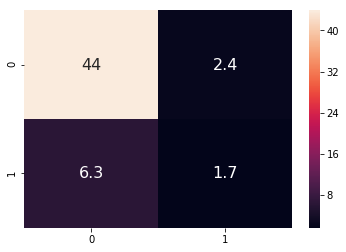

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
preds = clf.predict(X_test)
cm = confusion_matrix(y_test,preds)
sns.heatmap(cm/1000, annot=True,annot_kws={"size": 16})

## The Lookalike Approach

Instead of using a model to predict if an athelete is a medalist or not we can reshape the problem as **which atheletes look like medalists the most**. This is especially useful for use cases with imbalanced data in real life. For instance, a retailer might have only 1% of its customer buying both online and offline. If we use a supervised model, we will end up with poor performance like above but that is not because the model is bad but maybe because those customers are still untapped and can be converted.

We can either use supervised model to target them or find the similarity based on our available features. The upside of the lookalike approach is that it is very easy to explain intuitively. We are just finding those who looks like the people we know we want.

**Conceptual Assignment** The following function takes an input of two feature vectors and return [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). For each line, 

1. What linear algebra operations are being done?
2. What are the dimensions of input and output?

Tensorflow 2 is quite fast at matrix multiplication so we advise you try using it. See [how-to](https://www.tensorflow.org/install/).

In [14]:
import tensorflow as tf

def get_sim(f0,f1): 
    dot_product =  f0 @ tf.transpose(f1)
    f0_norm = tf.norm(f0,axis=1)
    f1_norm = tf.norm(f1,axis=1)
    return tf.reduce_mean(dot_product / (f0_norm[:,None]  * f1_norm[None,:]),1).numpy()

feat_tensor = tf.convert_to_tensor(X_train, dtype='float32')
feat_1 = tf.convert_to_tensor(X_train[y_train==1], dtype='float32')
ds = tf.data.Dataset.from_tensor_slices(feat_tensor).batch(3000)
feat_tensor.shape, feat_1.shape

(TensorShape([216892, 47]), TensorShape([31799, 47]))

In [ ]:
import tqdm
sims = []
for f0 in tqdm.tqdm(ds):
    sims.append(get_sim(f0,feat_1))

48it [01:14,  1.44s/it]

In [ ]:
s = np.concatenate(sims)
s.max(),s.min(),(s>0).sum()

In [ ]:
plt.hist(s)

In [ ]:
plt.hist(s[y_train==1])

In [ ]:
#accuracy
((s>0).astype(int)==y_train).mean()

In [ ]:
#confusion matrix
preds = (s>0).astype(int)
cm = confusion_matrix(y_train,preds)
sns.heatmap(cm/1000, annot=True,annot_kws={"size": 16})